# SkillFactory
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [7]:
df_descr = pd.read_csv('data/otp_description.csv', sep='\t', encoding='utf8')

In [8]:
df_descr.describe;

Считаем обучающую выборки и тестовую (которую мы как бы не видим)

In [9]:
df_train = pd.read_csv('data/otp_train.csv', sep='\t', encoding='utf8')

In [10]:
df_train.shape;

In [11]:
df_test = pd.read_csv('data/otp_test.csv', sep='\t', encoding='utf8')

In [12]:
df_test.shape;

In [13]:
df_train.head();

## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [14]:
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'
df = df_test.append(df_train).reset_index(drop=True)
df.shape


(30133, 53)

### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [16]:
#df.info()

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

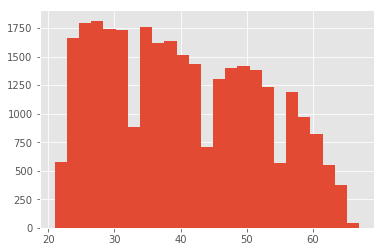

In [15]:
df['AGE'].hist(bins=25)
plt.show()

In [16]:
set(df['FAMILY_INCOME'])

{'до 5000 руб.',
 'от 10000 до 20000 руб.',
 'от 20000 до 50000 руб.',
 'от 5000 до 10000 руб.',
 'свыше 50000 руб.'}

In [19]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

EDUCATION
{'Среднее', 'Два и более высших образования', 'Неоконченное высшее', 'Неполное среднее', 'Ученая степень', 'Среднее специальное', 'Высшее'}


MARITAL_STATUS
{'Состою в браке', 'Вдовец/Вдова', 'Разведен(а)', 'Не состоял в браке', 'Гражданский брак'}


GEN_INDUSTRY
{nan, 'Другие сферы', 'ЧОП/Детективная д-ть', 'Образование', 'Банк/Финансы', 'Сельское хозяйство', 'Нефтегазовая промышленность', 'Государственная служба', 'Строительство', 'Транспорт', 'Здравоохранение', 'Страхование', 'Информационные технологии', 'Логистика', 'Энергетика', 'СМИ/Реклама/PR-агенства', 'Торговля', 'Маркетинг', 'Недвижимость', 'Туризм', 'Ресторанный бизнес/Общественное питание', 'Наука', 'Управляющая компания', 'Металлургия/Промышленность/Машиностроение', 'Юридические услуги/нотариальные услуги', 'Химия/Парфюмерия/Фармацевтика', 'Развлечения/Искусство', 'Подбор персонала', 'Салоны красоты и здоровья', 'Сборочные производства', 'Коммунальное хоз-во/Дорожные службы', 'Информационные услуги'}


GEN_TITLE


Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [20]:
df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float');

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Что с ними сделать?

(единственного верного ответа нет - аргументируйте)

 Числовые переменные  пропуски заполним медианным значением
```python
df_output['WORK_TIME'].fillna(value=np.round(df_output['WORK_TIME'].median(),decimals=2), inplace=True)
```
Строковые переменные заполним следующим непустым значением:
```python
  for col in ['GEN_INDUSTRY', 'GEN_TITLE', \
                'ORG_TP_STATE', 'JOB_DIR',
               'TP_PROVINCE', 'REGION_NM']:
        df_output[col].fillna(method='ffill',inplace=True)
```

#### Задание 2. Есть ли категориальные признаки? Что с ними делать?

Категориальные признаки разобьём на матрицы [0,1] через wrapper для OneHotEncoding pd.get_dummies():
```python
df_output = pd.get_dummies(df_output,columns=list_str)
```

Также может сработать ( у меня не сработало) перевод дохода из категориального признака в значение, в этом случае берём среднее значение в рублях для группы.
Перевод возраста в несколько категориальных групп ( для 5 категориальных групп у меня не стало лучше)

## Перевод дохода из категориального признака в значение
## Перевод возраста в несколько категориальных групп

In [22]:
def val_limit_bal(row):
    val = row['FAMILY_INCOME']
    if val == 'до 5000 руб.':
        return 2500
    elif val == 'от 10000 до 20000 руб.':
        return 15000
    elif val == 'от 20000 до 50000 руб.':
        return 25000
    elif val == 'от 5000 до 10000 руб.':
        return 7500
    elif val == 'свыше 50000 руб.':
        return 75000

#print (word_limit_bal(800000))

#df['FAMILY_INCOME_VAL'] = df.apply(val_limit_bal, axis = 1)
df.head();

In [23]:
def val_age(row):
    val = row['AGE']
    if 20 <=val<=30:
        return 'возрастн_группа_1'
    elif 31 <=val <=40:
        return 'возрастн_группа_2'
    elif 41<=val <=50:
        return 'возрастная группа_3'
    elif 51<=val <=60: 
        return 'возрастная группа_4'
    elif 61<=val:  
        return 'возрастная группа_5'

#print (word_limit_bal(800000))

# df['AGE_GROUPP'] = df.apply(val_age, axis = 1)
df.head();

#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками
* Кодировала категориальные признаки

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [19]:
import numpy as np

def list_nan_data(df):
    return df.columns[df.isnull().any()].tolist()

def return_list_str(df):
    return df.select_dtypes(exclude=[np.number]).columns.values.tolist()

def preproc_data(df_input):
    df_output = df_input.copy()
    # Handling duplicates       
    df_output.drop_duplicates(subset=['AGREEMENT_RK'], inplace = True)
    
    # Во всех числовых коломнах меняем , на . 
    list_code = ['CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']
    for el in list_code:
        df_output[el] = df_output[el].map(lambda x: x.replace(',','.')).astype('float')   
    
    print (type(df_output.loc[0,'CREDIT']))
    
    # Заполнили следующим текстовым значением из этого же списка
    # 'отрасль работы клиента', 'должность', 
    #'форма собственности компании' , 'направление деятельности в нутри компании'
    # 'область торговой точки, где клиент брал послед', 'регион' - возможно лишние значения
    for col in ['GEN_INDUSTRY', 'GEN_TITLE', \
                'ORG_TP_STATE', 'JOB_DIR',
               'TP_PROVINCE', 'REGION_NM']:
        df_output[col].fillna(method='ffill',inplace=True)
    # Медиана для числового значения месяца
    # for col in ['WORK_TIME']:
    df_output['WORK_TIME'].fillna(value=np.round(df_output['WORK_TIME'].median(),decimals=2), inplace=True)
    
    
    # отношение к иностранному капиталу, количество уже утилизированных карт   
    # df_output.drop('AGE', axis=1, inplace=True)
    #df_output.drop('FAMILY_INCOME', axis=1, inplace=True)
    df_output.drop(['ORG_TP_FCAPITAL', 'PREVIOUS_CARD_NUM_UTILIZED'], axis=1, inplace=True)
    
    # Во всех строковых коломнах меняем пробел на _ и , на . 
    # print (return_list_str(df_output))
    for col in return_list_str(df_output):
        # print (col)
        df_output[col] = df_output[col].str.replace(' ', '_')
        df_output[col] = df_output[col].str.replace(',', '.')
        
    # Разметить категориальные признаки кроме последней 'sample'
    list_str = [
    'EDUCATION',
    'AGE',
    'FAMILY_INCOME',
     'MARITAL_STATUS',
     'GEN_INDUSTRY',
     'GEN_TITLE',
     'ORG_TP_STATE',
     'JOB_DIR',
     'PERSONAL_INCOME',
     'REG_ADDRESS_PROVINCE',
     'FACT_ADDRESS_PROVINCE',
     'POSTAL_ADDRESS_PROVINCE',
     'TP_PROVINCE',
     'REGION_NM'
     ]
    df_output = pd.get_dummies(df_output,columns=list_str)
    
    return df_output

In [20]:
df_preproc = df.pipe(preproc_data)
df_preproc.head();

<class 'numpy.float64'>


In [21]:
df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

#### Задание 4. Отделите целевую переменную и остальные признаки

Должно получится:
* 2 матрицы: X и X_test
* 2 вектора: y и y_test

In [22]:
from sklearn.model_selection import train_test_split

# Делим на известную и неизвестную часть данных (вторая тестовая, но на ней тестируется сама модель)
df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

# Таргеты клиентов тренировочные данные
y_train_target = df_train_preproc['TARGET']
y_test_target = df_test_preproc['TARGET']

# Прячем таргеты из обеих выборок
y_train_preproc = df_train_preproc.drop('TARGET', axis =1)
y_test_preproc = df_test_preproc.drop('TARGET', axis =1)

X_train, X_test, y_train, y_test = train_test_split(y_train_preproc, y_train_target, test_size = 0.3,\
                                                    random_state = 42)

#### Задание 5. Обучение и оценка качества разных моделей

In [23]:
# Попробовать следующие "черные ящики": интерфейс одинаковый 
# Постепенно мы узнаем, что они делают а сейчас учимся понимать какой работает качественнее
#     fit, 
#     predict, 
#     predict_proba

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
solvers = {
    'rfc' : RandomForestClassifier(),
    'lr' : LogisticRegression(),
    'dtc' : DecisionTreeClassifier()
}

solvers_fit ={
    'rfc' : solvers['rfc'].fit(X_train, y_train),
    'lr' : solvers['lr'].fit(X_train, y_train),
    'dtc' : solvers['dtc'].fit(X_train, y_train)
}


In [24]:
predicts = {
    'rfc' : solvers_fit['rfc'].predict(X_test),
    'lr' : solvers_fit['lr'].predict(X_test),
    'dtc' : solvers_fit['dtc'].predict(X_test)
}

In [25]:
# Посчитать метрики стандартные
# accuracy, precision, recall

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve


precision_scores = {
    'dtc' : precision_score(y_test, predicts['dtc']),
    'rfc' : precision_score(y_test, predicts['rfc']),
    'lr' : precision_score(y_test, predicts['lr'])
}
recall_scores = {
    'dtc' : recall_score(y_test, predicts['dtc']),
    'rfc' : recall_score(y_test, predicts['rfc']),
    'lr' : recall_score(y_test, predicts['lr'])
}
accuracy_scores = {
    'dtc' : accuracy_score(y_test, predicts['dtc']),
    'rfc' : accuracy_score(y_test, predicts['rfc']),
    'lr' : accuracy_score(y_test, predicts['lr'])
}
average_precisions = {
    'dtc' : average_precision_score(y_test, predicts['dtc']),
    'rfc' : average_precision_score(y_test, predicts['rfc']),
    'lr' : average_precision_score(y_test, predicts['lr'])
}

for key in predicts.keys():
    print ('For solver', key, 'precision_score is', precision_scores[key])
    print ('For solver', key, 'recall_score is', recall_scores[key])
    print ('For solver', key, 'accuracy_score is', accuracy_scores[key])
    print('Average precision-recall for ', key, 'score: {0:0.2f}'.format(average_precisions[key]))
    print ('*'*10)

For solver rfc precision_score is 0.13333333333333333
For solver rfc recall_score is 0.0036036036036036037
For solver rfc accuracy_score is 0.8760674403328225
Average precision-recall for  rfc score: 0.12
**********
For solver lr precision_score is 0.0
For solver lr recall_score is 0.0
For solver lr accuracy_score is 0.8784760236479089
Average precision-recall for  lr score: 0.12
**********
For solver dtc precision_score is 0.16129032258064516
For solver dtc recall_score is 0.15315315315315314
For solver dtc accuracy_score is 0.8003065469673747
Average precision-recall for  dtc score: 0.13
**********


C:\Anaconda332\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.0, 1.0)

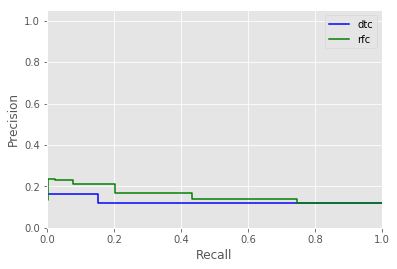

In [28]:
# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

pres_rec_plot ={
    'dtc': {
        'precision' : -1,
        'recall' : -1,
        'thresholds' : -1},
    'rfc': {
        'precision' : -1,
        'recall' : -1,
        'thresholds' : -1},
    'lr': {
        'precision' : -1,
        'recall' : -1,
        'thresholds' : -1}
}
for solver in pres_rec_plot.keys():    
    pres_rec_plot[solver]['precision'], pres_rec_plot[solver]['recall'], pres_rec_plot[solver]['thresholds']= \
                                        precision_recall_curve(y_test, predict_probas[solver][:,1])
        
plt.step(pres_rec_plot['dtc']['recall'], pres_rec_plot['dtc']['precision'], color='b', where='post')
plt.step(pres_rec_plot['rfc']['recall'], pres_rec_plot['rfc']['precision'], color='g', where='post')
plt.legend(['dtc', 'rfc'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])




(-0.01, 1.01)

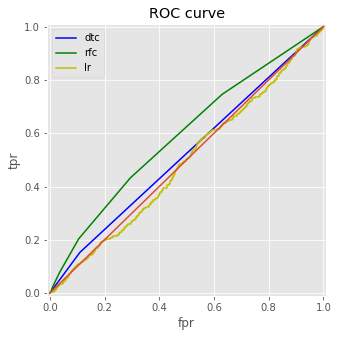

In [30]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

predict_probas = {
    'dtc' : solvers_fit['dtc'].predict_proba(X_test),
    'rfc' : solvers_fit['rfc'].predict_proba(X_test),
    'lr' : solvers_fit['lr'].predict_proba(X_test)
}
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

roc_plot ={
    'dtc': {
        'fpr' : -1,
        'tpr' : -1,
        'thresholds' : -1},
    'rfc': {
        'fpr' : -1,
        'tpr' : -1,
        'thresholds' : -1},
    'lr': {
        'fpr' : -1,
        'tpr' : -1,
        'thresholds' : -1}
}
for solver in roc_plot.keys():    
    roc_plot[solver]['fpr'], roc_plot[solver]['tpr'], roc_plot[solver]['thresholds']= \
                                        roc_curve(y_test, predict_probas[solver][:,1])

plt.figure(figsize=(5, 5))
plt.plot(roc_plot['dtc']['fpr'], roc_plot['dtc']['tpr'], 'b')                                 
plt.plot(roc_plot['rfc']['fpr'], roc_plot['rfc']['tpr'], 'g')
plt.plot(roc_plot['lr']['fpr'], roc_plot['lr']['tpr'], 'y')
                                 
plt.legend(['dtc','rfc', 'lr'])

plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))


## roc_auc каждой модели

In [33]:
roc_auc_scores ={
    'dtc': -1,
    'rfc': -1,
    'lr': -1
}
for solver in roc_auc_scores.keys():    
    roc_auc_scores[solver] = roc_auc_score(y_test, predict_probas[solver][:,1])
roc_auc_scores

{'dtc': 0.5214918308138646,
 'lr': 0.4898799098200893,
 'rfc': 0.5920549163320848}

In [35]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

cross_val_scores = {
    'rfc' : cross_val_score(
        RandomForestClassifier(),
        X_train,
        y_train,
        scoring='roc_auc',
        cv=10),

    'dtc' : cross_val_score(
        DecisionTreeClassifier(),
        X_train,
        y_train,
        scoring='roc_auc',
        cv=10),
    
    'lr' : cross_val_score(
        LogisticRegression(),
        X_train,
        y_train,
        scoring='roc_auc',
        cv=10),
}

for solver in cross_val_scores.keys():
    print ('Average roc_auc for model', solver, cross_val_scores[solver].mean())
    print ('*'*10)

Average roc_auc for model rfc 0.5685998168307269
**********
Average roc_auc for model dtc 0.5250299782152001
**********
Average roc_auc for model lr 0.494442682173905
**********


In [37]:
# Взять лучшую модель и сделать предсказания (с вероятностями (!!!)) для test выборки

predict_tests = {
    'rfc' : solvers_fit['rfc'].predict(y_test_preproc),
}
precision_scores_test = {
    'rfc' : precision_score(y_test_target, predict_tests['rfc']),
}
recall_scores_test = {
    'rfc' : recall_score(y_test_target, predict_tests['rfc']),
}
accuracy_scores_test = {
    'rfc' : accuracy_score(y_test_target, predict_tests['rfc']),
}
average_precisions_test = {
    'rfc' : average_precision_score(y_test_target, predict_tests['rfc'])
}

for key in predict_tests.keys():
    print ('For solver', key, 'precision_score is', precision_scores_test[key])
    print ('For solver', key, 'recall_score is', recall_scores_test[key])
    print ('For solver', key, 'accuracy_score is', accuracy_scores_test[key])
    print('Average precision-recall for ', key, 'score: {0:0.2f}'.format(average_precisions_test[key]))
    print ('*'*10)

predict_probas_test = {
    'rfc' : solvers_fit['rfc'].predict_proba(y_test_preproc)
}
# Вероятности
predict_probas_test['rfc'][:,1]

For solver rfc precision_score is 0.18604651162790697
For solver rfc recall_score is 0.004571428571428572
For solver rfc accuracy_score is 0.8808182427900738
Average precision-recall for  rfc score: 0.12
**********


array([0. , 0.1, 0.3, ..., 0.1, 0. , 0.3])

(-0.01, 1.01)

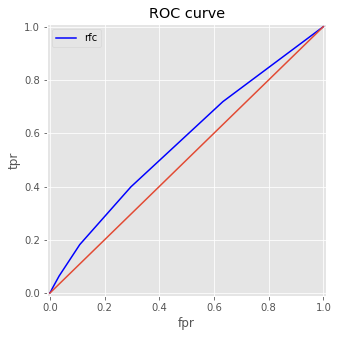

In [39]:
# Померить roc_auc на тесте
# Вывести текстом и на графике =)

roc_plot_test ={
    'rfc': {
        'fpr' : -1,
        'tpr' : -1,
        'thresholds' : -1},
}
for solver in roc_plot_test.keys():    
    roc_plot_test[solver]['fpr'], roc_plot_test[solver]['tpr'], roc_plot_test[solver]['thresholds']= \
                                        roc_curve(y_test_target, predict_probas_test[solver][:,1])
    
plt.figure(figsize=(5, 5))
plt.plot(roc_plot_test['rfc']['fpr'], roc_plot_test['rfc']['tpr'], 'b')                                 
                                 
plt.legend(['rfc'])

plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

# roc_auc_scores_test - для тестовой выборки

In [41]:
roc_auc_scores_test ={
    'rfc': -1
}
for solver in roc_auc_scores_test.keys():   
    roc_auc_scores_test[solver] = roc_auc_score(y_test_target, predict_probas_test[solver][:,1])
roc_auc_scores_test

{'rfc': 0.5682002388189318}

### Больше обязательных заданий нет, но ниже вы можете провести исследование, поиграться с данными
### Это возможность написать код, который я посмотрю и в случае чего откомметирую. ;)
### Это не оценивается и остается на ваше усмотрение. Просто дополнительная возможность

In [1]:
### И далее ;)
? Есть ли способ сохранять графики и значения метрик при исследовании. Например, я хочу проверить гипотезу, что 
разбиение колонны возрастов на группу из 5 интервалов как-то повлияет на результат. Мне нужно сохранить 
предыдущие графики и метрики. Как это удобно сделать?
? Для каждого такого исследования мне нужно делать новый df.pipeline? Получается эффект бабочки, если я делаю 
группировку в столбце в начале (добавляю, удаляю столбец), далее по коду во многих местах 
в коде приходится делать исправления. А если мне нужно откатиться назад, например, прежний результат был лучше?
? Хорошая ли практика использовать словари для хранения метрик, параметров, типа_ящика для модели, как в 
я делал в приведённом выше коде. Как я вижу, это немного убирает сложность и работать с исследованием легче. Но 
в дальнейшим рост сложности (количества веток) приведёт к тому, что с кодом станет тяжело работать. Нужна
какая-то смесь функционального и объектного подхода. Есть какие-нибудь эффективные практики, в 
какую сторону смотреть? Спасибо.